## Final Project Submission

Please fill out:
* Student name: David Braslow
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:


# Overview

# Initialization

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score
import pickle
import gc

In [2]:
tqdm.pandas()

In [3]:
INPUT = 'raw_files/'
TEXT_COL = 'comment_text'

## Data Import

In [4]:
train = pd.read_csv(INPUT + 'train.csv').sample(frac = 0.10, random_state = 123)

In [5]:
test = pd.read_csv(INPUT + 'test.csv')

# Data Scrubbing

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180487 entries, 687256 to 1094397
Data columns (total 45 columns):
id                                     180487 non-null int64
target                                 180487 non-null float64
comment_text                           180487 non-null object
severe_toxicity                        180487 non-null float64
obscene                                180487 non-null float64
identity_attack                        180487 non-null float64
insult                                 180487 non-null float64
threat                                 180487 non-null float64
asian                                  40596 non-null float64
atheist                                40596 non-null float64
bisexual                               40596 non-null float64
black                                  40596 non-null float64
buddhist                               40596 non-null float64
christian                              40596 non-null float64
female    

In [7]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
687256,1082203,0.000000,"""And I always say that if I ever believed Cana...",0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,...,317079,rejected,0,0,0,0,0,0.0,4,6
1728190,6241244,0.166667,"have to be fan today; not player. +3 or, +1.5,...",0.0,0.0,0.000000,0.166667,0.0,NaN,NaN,...,394471,approved,0,0,0,1,0,0.0,0,6
1733028,6247184,0.166667,It will help him get impeached for treason.,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,394751,approved,1,0,0,3,3,0.0,0,6
1073761,5428926,0.000000,To me there is a real disconnect when one says...,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,344947,approved,1,0,0,10,0,0.0,0,4
541700,905935,0.000000,We have a spending problem John. I refuse to a...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,164337,approved,0,0,0,1,1,0.0,4,4


In [8]:
train.loc[687256]['comment_text']

'"And I always say that if I ever believed Canada was really the Canada of Stephen Harper and we were going against abortion and going against gay marriage, and we were going backward in 10,000 different ways, maybe I\'d think of wanting to make Quebec a country." ~  Justin Trudeau when he was an MP during a radio interview with  host Franco Nuovo in February 2012.\n\nDuring the talk show, when Nuovo expressed surprise at Trudeau\'s remarks, Trudeau doubled down: "Oh yes, absolutely. If I no longer recognized Canada, I know my own values."\n\nHowever to be fair to the Tater Tot he was but a callow youth of 41 years of age at the time... just a seed potato eh?\n\nThat sound you heard was Pierre Trudeau turning over in his grave.'

In [9]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


## Cleaning Text

In [10]:
def clean_text(x):
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~&' + '“”’':
        x = x.replace(punct, '')
    return x

In [11]:
train['text_clean'] = train['comment_text'].progress_apply(clean_text)
train['text_clean'].head()

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:03<00:00, 59744.09it/s]


687256     And I always say that if I ever believed Canad...
1728190    have to be fan today not player 3 or 15 take y...
1733028           It will help him get impeached for treason
1073761    To me there is a real disconnect when one says...
541700     We have a spending problem John I refuse to ac...
Name: text_clean, dtype: object

## Tokenizing

In [12]:
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [13]:
BERT_MODEL = 'bert-base-uncased'
CASED = 'uncased' in BERT_MODEL
MAXLEN = 220

In [14]:
#Import BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case = CASED)

In [15]:
train['text_tokens'] = train['text_clean'].progress_apply(tokenizer.tokenize)
train['text_tokens'].head()

100%|█████████████████████████████████████████████████████████████████████████| 180487/180487 [04:02<00:00, 745.41it/s]


687256     [and, i, always, say, that, if, i, ever, belie...
1728190    [have, to, be, fan, today, not, player, 3, or,...
1733028    [it, will, help, him, get, imp, ##ea, ##ched, ...
1073761    [to, me, there, is, a, real, disco, ##nne, ##c...
541700     [we, have, a, spending, problem, john, i, refu...
Name: text_tokens, dtype: object

## Encoding

### Checking Vocabulary Coverage

In [16]:
tokenizer.save_vocabulary('vocab')
bert_vocab_file = open('vocab\\vocab.txt', encoding='utf-8')
bert_vocab_list = bert_vocab_file.read().split(sep = '\n')
bert_vocab_dict = {x: True for x in bert_vocab_list}

In [17]:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [18]:
train_sentences = train['text_tokens'].values
train_vocab = build_vocab(train_sentences)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:02<00:00, 70064.85it/s]


In [19]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [20]:
check_coverage(train_vocab, bert_vocab_dict)[0:20]

100%|███████████████████████████████████████████████████████████████████████| 26234/26234 [00:00<00:00, 1093260.32it/s]


Found embeddings for 100.00% of vocab
Found embeddings for  100.00% of all text


[]

### Encoding Comments

In [21]:
train['text_ids'] = train['text_tokens'].progress_apply(tokenizer.convert_tokens_to_ids)
train['text_ids'].head(10)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:03<00:00, 45878.70it/s]


687256     [1998, 1045, 2467, 2360, 2008, 2065, 1045, 241...
1728190    [2031, 2000, 2022, 5470, 2651, 2025, 2447, 101...
1733028    [2009, 2097, 2393, 2032, 2131, 17727, 5243, 76...
1073761    [2000, 2033, 2045, 2003, 1037, 2613, 12532, 10...
541700     [2057, 2031, 1037, 5938, 3291, 2198, 1045, 102...
900691     [1045, 1049, 2025, 1037, 5470, 1997, 8398, 200...
393193     [2481, 1056, 2022, 1037, 2488, 2447, 2652, 200...
1121977    [2045, 2024, 1037, 2843, 1997, 2822, 2231, 512...
1411658    [4067, 2017, 2005, 2023, 23259, 14764, 2009, 2...
300499     [1996, 3145, 2003, 2008, 2017, 3685, 5860, 200...
Name: text_ids, dtype: object

### Clipping

In [22]:
def id_clip(ids, num_ids = MAXLEN):
    ids_clipped = list(np.zeros(num_ids, dtype=np.int))
    i = 0
    while (i < num_ids) & (i < len(ids)):
        ids_clipped[i] = ids[i]
        i += 1
    return np.array(ids_clipped)

In [23]:
train['text_ids_clipped'] = train['text_ids'].progress_apply(id_clip)
train['text_ids_clipped'].head()

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:10<00:00, 17991.12it/s]


687256     [1998, 1045, 2467, 2360, 2008, 2065, 1045, 241...
1728190    [2031, 2000, 2022, 5470, 2651, 2025, 2447, 101...
1733028    [2009, 2097, 2393, 2032, 2131, 17727, 5243, 76...
1073761    [2000, 2033, 2045, 2003, 1037, 2613, 12532, 10...
541700     [2057, 2031, 1037, 5938, 3291, 2198, 1045, 102...
Name: text_ids_clipped, dtype: object

# Exploring the Data

In [24]:
import matplotlib.pyplot as plt

## Comment Length

In [25]:
train['text_id_len'] = train['text_ids'].progress_apply(len)
train['text_id_len'].describe()

100%|██████████████████████████████████████████████████████████████████████| 180487/180487 [00:00<00:00, 997059.40it/s]


count    180487.000000
mean         56.579233
std          50.365195
min           0.000000
25%          19.000000
50%          39.000000
75%          79.000000
max         307.000000
Name: text_id_len, dtype: float64

Text(0.5, 1.0, 'Comment Length')

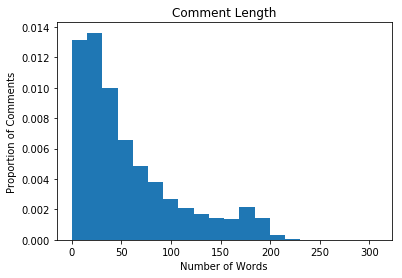

In [26]:
plt.hist(train['text_id_len'].values, bins=20, density = True)
plt.xlabel('Number of Words')
plt.ylabel('Proportion of Comments')
plt.title('Comment Length')

## Identity Groups

In [27]:
identity_columns = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']

In [28]:
identity_prop = train[identity_columns].describe().loc['mean']
type(identity_prop)

pandas.core.series.Series

In [29]:
print(identity_prop)

male                             0.107505
female                           0.128989
homosexual_gay_or_lesbian        0.025013
christian                        0.094331
jewish                           0.018731
muslim                           0.050115
black                            0.035395
white                            0.057116
psychiatric_or_mental_illness    0.011779
Name: mean, dtype: float64


Text(0.5, 1.0, 'Incidence of Identity Group Comments')

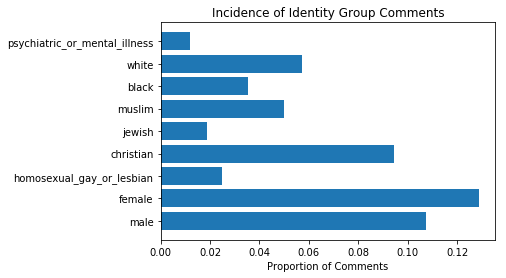

In [30]:
y_pos = np.arange(len(identity_prop))

plt.barh(y_pos, identity_prop.values, align='center')
plt.yticks(y_pos, identity_prop.index)
plt.xlabel('Proportion of Comments')
plt.title('Incidence of Identity Group Comments')

## Toxicity (Target)

count    180487.000000
mean          0.103197
std           0.197017
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

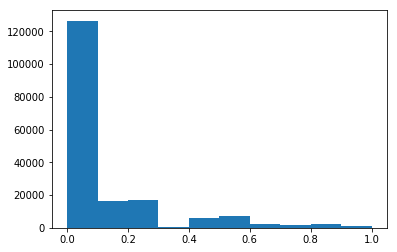

In [31]:
plt.hist(train['target'])
train['target'].describe()

In [32]:
np.mean(np.round(train['target'].values))

0.058874046330206604

### Toxicity by Subgroup

In [33]:
train[identity_columns].mean()

male                             0.107505
female                           0.128989
homosexual_gay_or_lesbian        0.025013
christian                        0.094331
jewish                           0.018731
muslim                           0.050115
black                            0.035395
white                            0.057116
psychiatric_or_mental_illness    0.011779
dtype: float64

In [34]:
identity_toxic_props = pd.Series()
for identity in identity_columns:
    identity_df = train[train[identity] >= 0.5]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    pct_toxic = np.round(n_toxic/n_tot * 100, decimals = 1) 
    print(f"{identity}: {pct_toxic}%")
    identity_toxic_props[identity] = n_toxic/n_tot
    
print(identity_toxic_props)

male: 10.4%
female: 9.0%
homosexual_gay_or_lesbian: 20.5%
christian: 5.5%
jewish: 9.0%
muslim: 13.7%
black: 22.3%
white: 18.7%
psychiatric_or_mental_illness: 12.5%
male                             0.103737
female                           0.090408
homosexual_gay_or_lesbian        0.204819
christian                        0.055275
jewish                           0.090235
muslim                           0.136748
black                            0.222947
white                            0.186857
psychiatric_or_mental_illness    0.124736
dtype: float64


Text(0.5, 1.0, 'Incidence of Toxic Identity Group Comments')

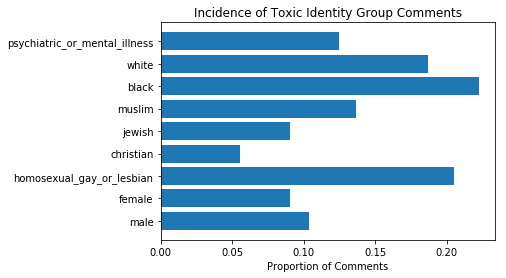

In [35]:
y_pos = np.arange(len(identity_toxic_props))

plt.barh(y_pos, identity_toxic_props.values, align='center')
plt.yticks(y_pos, identity_toxic_props.index)
plt.xlabel('Proportion of Comments')
plt.title('Incidence of Toxic Identity Group Comments')

In [36]:
identity_columns_long = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white']
for identity in identity_columns_long:
    identity_df = train[train[identity] >= 0.5]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    if n_tot == 0:
        continue
    pct_toxic = np.round(n_toxic/n_tot * 100, decimals = 1) 
    print(f"{identity}: {pct_toxic}%")

asian: 9.8%
atheist: 7.1%
bisexual: 21.4%
black: 22.3%
buddhist: 4.8%
christian: 5.5%
female: 9.0%
heterosexual: 15.7%
hindu: 5.2%
homosexual_gay_or_lesbian: 20.5%
intellectual_or_learning_disability: 0.0%
jewish: 9.0%
latino: 12.3%
male: 10.4%
muslim: 13.7%
other_disability: 50.0%
other_race_or_ethnicity: 18.2%
other_religion: 0.0%
physical_disability: 0.0%
psychiatric_or_mental_illness: 12.5%
transgender: 14.9%
white: 18.7%


## Toxic Words

### Identify Important Words with TF-IDF

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer(max_features=20000)
count_vectorizer.fit(train['comment_text'].values)
top_20000_words = count_vectorizer.get_feature_names()
top_20000_words[0:10]

['00', '000', '001', '01', '02', '03', '04', '05', '06', '07']

In [38]:
gc.collect()
count_mat = count_vectorizer.transform(train['comment_text'].values)

In [39]:
np.sum((count_mat[:,0] >= 1).toarray())

343

In [40]:
df = train[['target']]
df['target'] = df['target'].apply(np.round)
word_dict = {}
for i, word in enumerate(top_20000_words):
    count_docs = count_mat[:,i] >= 1
    num_docs = np.sum(count_docs)
    if num_docs < 300:
        # print(word, num_docs)
        continue
    pres_mat = count_docs.toarray().flatten()
    df['pres'] = pd.Series(pres_mat)
    # print(word, num_docs, df.groupby('pres').mean())
    word_dict[word] = (num_docs, df.groupby('pres').mean().values[0,0],  df.groupby('pres').mean().values[1, 0])
print(word_dict)

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


{'00': (343, 0.05683212493028444, 0.03125), '000': (2605, 0.05711705610114008, 0.03278688524590164), '10': (2958, 0.056861858467103774, 0.05185185185185185), '100': (1973, 0.05656770130454341, 0.07865168539325842), '11': (992, 0.0565847652096043, 0.09473684210526316), '12': (1127, 0.05679524557075578, 0.05555555555555555), '13': (547, 0.05690194326557963, 0.018518518518518517), '14': (530, 0.05682706263257787, 0.041666666666666664), '15': (1358, 0.056790123456790124, 0.056338028169014086), '150': (314, 0.05688472477831688, 0.0), '16': (679, 0.05689375733527078, 0.028985507246376812), '17': (523, 0.056833407771326484, 0.04), '18': (684, 0.0568619784393677, 0.03389830508474576), '19': (409, 0.05681437660453176, 0.045454545454545456), '1st': (329, 0.056822617520771765, 0.034482758620689655), '20': (2083, 0.05658360987682097, 0.07650273224043716), '200': (562, 0.056705921750293015, 0.08888888888888889), '2008': (378, 0.05685114929703191, 0.02631578947368421), '2012': (307, 0.05682895544029

In [41]:
word_freq = pd.DataFrame.from_dict(word_dict, orient = 'index', columns = ['Count', 'PctNonToxic', 'PctToxic'])
word_freq = word_freq.sort_values('PctToxic', ascending = False)
print(len(word_freq))
word_freq.head(20)

2690


,Count,PctNonToxic,PctToxic
writer,526,0.056464,0.205128
stage,336,0.056510,0.194444
repeatedly,312,0.056590,0.192308
fewer,403,0.056600,0.172414
notion,344,0.056603,0.166667
sale,415,0.056569,0.162162
classes,314,0.056606,0.161290
fools,313,0.056609,0.156250
ugly,321,0.056612,0.151515
sake,324,0.056579,0.150000


# Modeling the Data

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf

Using TensorFlow backend.


## Create Evaluator Class

In [43]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90527#latest-527799
import numpy as np
from sklearn.metrics import roc_auc_score


class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

## Create Modeling Dataframes

In [44]:
identity_columns = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']
y_identities = train[identity_columns].apply(round).values

In [45]:
tr_ind, val_ind = train_test_split(list(range(len(train))) ,test_size = 0.05, random_state = 123)

## Model 1: Bag of Words with MultinomialNB

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [47]:
x_train = train['text_clean'].values

In [48]:
y_train = train['target'].apply(np.round).values

In [49]:
vectorizer = TfidfVectorizer(max_features = 20000)
tf_idf_data_train = vectorizer.fit_transform(x_train[tr_ind])
tf_idf_data_val = vectorizer.transform(x_train[val_ind])

In [50]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train[tr_ind])
nb_train_preds = nb_classifier.predict_proba(tf_idf_data_train)
nb_val_preds = nb_classifier.predict_proba(tf_idf_data_val)

In [51]:
train_JE = JigsawEvaluator(y_train[tr_ind],y_identities[tr_ind])
nb_train_score = train_JE.get_final_metric(nb_train_preds[:,1])
nb_train_score

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


0.8737509282540903

In [52]:
val_JE = JigsawEvaluator(y_train[val_ind],y_identities[val_ind])
nb_val_score = val_JE.get_final_metric(nb_val_preds[:,1])
nb_val_score

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


0.8265687465450164

### Subgroup Results

In [80]:
pd.DataFrame(val_JE.compute_bias_metrics_for_model(nb_val_preds[:,1]).T, 
             index = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness'], 
             columns = ['subgroup_auc', 'bpsn_auc', 'bnsp_auc'])

,subgroup_auc,bpsn_auc,bnsp_auc
male,0.827363,0.821042,0.871817
female,0.878968,0.835770,0.902631
homosexual_gay_or_lesbian,0.776596,0.734835,0.919077
christian,0.879928,0.893434,0.838908
jewish,0.689655,0.762786,0.807575
muslim,0.698570,0.800867,0.796747
black,0.877976,0.771091,0.941440
white,0.729234,0.735012,0.872635
psychiatric_or_mental_illness,0.976190,0.921769,0.925486


## Model 2: Bidirectional LSTM with BERT Embeddings

## BERT Embeddings

In [53]:
BERT_FP = 'bert-base-uncased'

In [54]:
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained(BERT_FP)
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

In [55]:
embedding_matrix = get_bert_embed_matrix()

### Create weights that prioritize comments with identity tags 

In [56]:
# Overall
weights = np.ones((len(train),)) / 4
# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

#loss_weight = 1.0 / weights.mean()

print(weights.shape)

(180487,)


In [57]:
y_train = np.vstack([(train['target'].values>=0.5).astype(np.int),weights]).T
x_train = np.vstack(train['text_ids_clipped'].to_numpy())

In [58]:
BATCH_SIZE = 128
EPOCHS = 6
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

In [59]:
tf.reset_default_graph()
gc.collect()

221

In [60]:
def build_model(embedding_matrix):
    '''
    credits go to: https://www.kaggle.com/thousandvoices/simple-lstm/
    '''
    words = Input(shape=(MAXLEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x)])
    x = Dropout(0.5)(x)
    x = Dense(DENSE_HIDDEN_UNITS, activation='relu')(x)
    x = Dropout(0.3)(x)
    result = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss=custom_loss, optimizer='adam')

    return model

In [61]:
def custom_loss(y_true, y_pred):
    return binary_crossentropy(K.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

In [62]:
model = build_model(embedding_matrix)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 768)     23440896    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 220, 768)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidi

In [63]:
from keras.utils import plot_model
plot_model(model, to_file='bi-lstm-model.png')

In [81]:
eval_scores = []
train_losses = []
val_losses = []
weights = []

for global_epoch in range(EPOCHS):
    history = model.fit(x_train[tr_ind],y_train[tr_ind],validation_data = (x_train[val_ind],y_train[val_ind]),
        batch_size=BATCH_SIZE,
        epochs=1,
        verbose=1,
        callbacks=[
            LearningRateScheduler(lambda epoch: 1e-3 * (0.8 ** global_epoch))
        ]
    )
    #checkpoint_predictions.append(model.predict(x_test, batch_size=BATCH_SIZE)[0].flatten())
    gc.collect()
    val_preds = model.predict(x_train[val_ind], batch_size=BATCH_SIZE)
    JE = JigsawEvaluator(y_train[val_ind][:,0],y_identities[val_ind])
    eval_scores.append(JE.get_final_metric(val_preds))
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 13:07 - loss: 0.07 - ETA: 11:44 - loss: 0.06 - ETA: 11:46 - loss: 0.06 - ETA: 11:45 - loss: 0.06 - ETA: 13:17 - loss: 0.05 - ETA: 12:49 - loss: 0.05 - ETA: 13:34 - loss: 0.06 - ETA: 13:17 - loss: 0.06 - ETA: 13:54 - loss: 0.06 - ETA: 13:19 - loss: 0.06 - ETA: 12:55 - loss: 0.06 - ETA: 12:31 - loss: 0.06 - ETA: 12:16 - loss: 0.07 - ETA: 12:03 - loss: 0.07 - ETA: 11:48 - loss: 0.06 - ETA: 11:33 - loss: 0.06 - ETA: 11:23 - loss: 0.06 - ETA: 11:12 - loss: 0.06 - ETA: 11:05 - loss: 0.06 - ETA: 11:20 - loss: 0.06 - ETA: 11:10 - loss: 0.06 - ETA: 11:00 - loss: 0.06 - ETA: 10:54 - loss: 0.06 - ETA: 11:07 - loss: 0.06 - ETA: 11:00 - loss: 0.06 - ETA: 11:02 - loss: 0.06 - ETA: 10:56 - loss: 0.06 - ETA: 10:49 - loss: 0.06 - ETA: 10:58 - loss: 0.06 - ETA: 10:54 - loss: 0.06 - ETA: 10:49 - loss: 0.06 - ETA: 10:48 - loss: 0.06 - ETA: 10:42 - loss: 0.06 - ETA: 10:39 - loss: 0.06 - ETA: 10:34 - loss: 0.06 - ETA: 10:31 - loss: 0.06 - ETA: 10:27 - lo

 80000/171462 [============>.................] - ETA: 7:51 - loss: 0.066 - ETA: 7:50 - loss: 0.066 - ETA: 7:50 - loss: 0.066 - ETA: 7:49 - loss: 0.066 - ETA: 7:48 - loss: 0.066 - ETA: 7:48 - loss: 0.066 - ETA: 7:47 - loss: 0.066 - ETA: 7:46 - loss: 0.066 - ETA: 7:47 - loss: 0.066 - ETA: 7:46 - loss: 0.066 - ETA: 7:46 - loss: 0.066 - ETA: 7:46 - loss: 0.066 - ETA: 7:45 - loss: 0.066 - ETA: 7:45 - loss: 0.066 - ETA: 7:45 - loss: 0.066 - ETA: 7:44 - loss: 0.066 - ETA: 7:43 - loss: 0.066 - ETA: 7:43 - loss: 0.066 - ETA: 7:43 - loss: 0.066 - ETA: 7:43 - loss: 0.066 - ETA: 7:42 - loss: 0.066 - ETA: 7:41 - loss: 0.066 - ETA: 7:41 - loss: 0.066 - ETA: 7:41 - loss: 0.066 - ETA: 7:40 - loss: 0.066 - ETA: 7:40 - loss: 0.066 - ETA: 7:40 - loss: 0.066 - ETA: 7:39 - loss: 0.066 - ETA: 7:39 - loss: 0.066 - ETA: 7:38 - loss: 0.066 - ETA: 7:37 - loss: 0.066 - ETA: 7:36 - loss: 0.066 - ETA: 7:36 - loss: 0.066 - ETA: 7:35 - loss: 0.066 - ETA: 7:34 - loss: 0.066 - ETA: 7:33 - loss: 0.066 - ETA: 7:33 - los

120192/171462 [====================>.........] - ETA: 5:24 - loss: 0.067 - ETA: 5:24 - loss: 0.067 - ETA: 5:23 - loss: 0.067 - ETA: 5:23 - loss: 0.067 - ETA: 5:22 - loss: 0.067 - ETA: 5:22 - loss: 0.067 - ETA: 5:21 - loss: 0.067 - ETA: 5:21 - loss: 0.067 - ETA: 5:21 - loss: 0.067 - ETA: 5:20 - loss: 0.067 - ETA: 5:19 - loss: 0.067 - ETA: 5:19 - loss: 0.067 - ETA: 5:19 - loss: 0.067 - ETA: 5:18 - loss: 0.067 - ETA: 5:18 - loss: 0.067 - ETA: 5:17 - loss: 0.067 - ETA: 5:17 - loss: 0.067 - ETA: 5:17 - loss: 0.067 - ETA: 5:17 - loss: 0.067 - ETA: 5:16 - loss: 0.067 - ETA: 5:16 - loss: 0.067 - ETA: 5:15 - loss: 0.067 - ETA: 5:15 - loss: 0.067 - ETA: 5:14 - loss: 0.067 - ETA: 5:14 - loss: 0.067 - ETA: 5:14 - loss: 0.067 - ETA: 5:13 - loss: 0.067 - ETA: 5:13 - loss: 0.067 - ETA: 5:12 - loss: 0.067 - ETA: 5:12 - loss: 0.067 - ETA: 5:11 - loss: 0.067 - ETA: 5:11 - loss: 0.067 - ETA: 5:10 - loss: 0.067 - ETA: 5:10 - loss: 0.067 - ETA: 5:10 - loss: 0.067 - ETA: 5:09 - loss: 0.067 - ETA: 5:09 - los

161024/171462 [===========================>..] - ETA: 3:00 - loss: 0.067 - ETA: 2:59 - loss: 0.067 - ETA: 2:59 - loss: 0.067 - ETA: 2:58 - loss: 0.067 - ETA: 2:58 - loss: 0.067 - ETA: 2:57 - loss: 0.067 - ETA: 2:57 - loss: 0.067 - ETA: 2:56 - loss: 0.067 - ETA: 2:56 - loss: 0.067 - ETA: 2:55 - loss: 0.067 - ETA: 2:54 - loss: 0.067 - ETA: 2:54 - loss: 0.067 - ETA: 2:53 - loss: 0.067 - ETA: 2:53 - loss: 0.067 - ETA: 2:52 - loss: 0.067 - ETA: 2:52 - loss: 0.067 - ETA: 2:51 - loss: 0.067 - ETA: 2:51 - loss: 0.067 - ETA: 2:50 - loss: 0.067 - ETA: 2:50 - loss: 0.067 - ETA: 2:49 - loss: 0.067 - ETA: 2:48 - loss: 0.067 - ETA: 2:48 - loss: 0.067 - ETA: 2:47 - loss: 0.067 - ETA: 2:47 - loss: 0.067 - ETA: 2:46 - loss: 0.067 - ETA: 2:46 - loss: 0.067 - ETA: 2:45 - loss: 0.067 - ETA: 2:45 - loss: 0.067 - ETA: 2:44 - loss: 0.067 - ETA: 2:44 - loss: 0.067 - ETA: 2:43 - loss: 0.067 - ETA: 2:43 - loss: 0.067 - ETA: 2:42 - loss: 0.067 - ETA: 2:42 - loss: 0.067 - ETA: 2:41 - loss: 0.067 - ETA: 2:40 - los

171462/171462 [==============================] - ETA: 31s - loss: 0.06 - ETA: 31s - loss: 0.06 - ETA: 30s - loss: 0.06 - ETA: 30s - loss: 0.06 - ETA: 29s - loss: 0.06 - ETA: 29s - loss: 0.06 - ETA: 29s - loss: 0.06 - ETA: 28s - loss: 0.06 - ETA: 28s - loss: 0.06 - ETA: 27s - loss: 0.06 - ETA: 27s - loss: 0.06 - ETA: 27s - loss: 0.06 - ETA: 26s - loss: 0.06 - ETA: 26s - loss: 0.06 - ETA: 25s - loss: 0.06 - ETA: 25s - loss: 0.06 - ETA: 25s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 23s - loss: 0.06 - ETA: 23s - loss: 0.06 - ETA: 23s - loss: 0.06 - ETA: 22s - loss: 0.06 - ETA: 22s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.06 - ETA: 16s - loss

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 4:45 - loss: 0.062 - ETA: 4:38 - loss: 0.067 - ETA: 4:38 - loss: 0.060 - ETA: 4:36 - loss: 0.061 - ETA: 4:36 - loss: 0.063 - ETA: 4:36 - loss: 0.062 - ETA: 4:39 - loss: 0.060 - ETA: 4:38 - loss: 0.055 - ETA: 4:29 - loss: 0.054 - ETA: 4:21 - loss: 0.056 - ETA: 4:23 - loss: 0.057 - ETA: 4:24 - loss: 0.059 - ETA: 4:25 - loss: 0.060 - ETA: 4:19 - loss: 0.062 - ETA: 4:20 - loss: 0.061 - ETA: 4:21 - loss: 0.060 - ETA: 4:21 - loss: 0.061 - ETA: 4:18 - loss: 0.060 - ETA: 4:18 - loss: 0.061 - ETA: 4:19 - loss: 0.061 - ETA: 4:20 - loss: 0.061 - ETA: 4:20 - loss: 0.061 - ETA: 4:31 - loss: 0.061 - ETA: 4:31 - loss: 0.060 - ETA: 4:31 - loss: 0.060 - ETA: 4:30 - loss: 0.060 - ETA: 4:30 - loss: 0.060 - ETA: 4:30 - loss: 0.059 - ETA: 4:29 - loss: 0.059 - ETA: 4:29 - loss: 0.058 - ETA: 4:29 - loss: 0.057 - ETA: 4:29 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:36 - loss: 0.057 - ETA: 4:42 - loss: 0.058 - ETA: 4:39 - loss: 0.058 - ETA: 4:39 - los

 80000/171462 [============>.................] - ETA: 3:34 - loss: 0.067 - ETA: 3:34 - loss: 0.067 - ETA: 3:33 - loss: 0.067 - ETA: 3:33 - loss: 0.067 - ETA: 3:33 - loss: 0.067 - ETA: 3:33 - loss: 0.067 - ETA: 3:33 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:32 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:31 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:30 - loss: 0.067 - ETA: 3:29 - loss: 0.067 - ETA: 3:29 - loss: 0.067 - ETA: 3:29 - loss: 0.067 - ETA: 3:28 - loss: 0.067 - ETA: 3:28 - loss: 0.067 - ETA: 3:28 - loss: 0.067 - ETA: 3:28 - loss: 0.067 - ETA: 3:28 - loss: 0.067 - ETA: 3:27 - loss: 0.067 - ETA: 3:27 - los

120192/171462 [====================>.........] - ETA: 2:26 - loss: 0.067 - ETA: 2:26 - loss: 0.067 - ETA: 2:26 - loss: 0.067 - ETA: 2:26 - loss: 0.067 - ETA: 2:26 - loss: 0.067 - ETA: 2:25 - loss: 0.067 - ETA: 2:25 - loss: 0.067 - ETA: 2:25 - loss: 0.067 - ETA: 2:25 - loss: 0.067 - ETA: 2:24 - loss: 0.067 - ETA: 2:24 - loss: 0.067 - ETA: 2:24 - loss: 0.067 - ETA: 2:24 - loss: 0.067 - ETA: 2:24 - loss: 0.067 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:21 - loss: 0.067 - ETA: 2:21 - loss: 0.067 - ETA: 2:21 - loss: 0.067 - ETA: 2:21 - loss: 0.067 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.067 - ETA: 2:19 - loss: 0.067 - ETA: 2:19 - loss: 0.067 - ETA: 2:19 - loss: 0.067 - ETA: 2:19 - loss: 0.067 - ETA: 2:19 - loss: 0.067 - ETA: 2:18 - los

162560/171462 [===========================>..] - ETA: 1:20 - loss: 0.066 - ETA: 1:20 - loss: 0.066 - ETA: 1:20 - loss: 0.066 - ETA: 1:20 - loss: 0.066 - ETA: 1:20 - loss: 0.066 - ETA: 1:19 - loss: 0.066 - ETA: 1:19 - loss: 0.066 - ETA: 1:19 - loss: 0.066 - ETA: 1:19 - loss: 0.066 - ETA: 1:18 - loss: 0.066 - ETA: 1:18 - loss: 0.066 - ETA: 1:18 - loss: 0.066 - ETA: 1:18 - loss: 0.066 - ETA: 1:18 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:17 - loss: 0.066 - ETA: 1:16 - loss: 0.066 - ETA: 1:16 - loss: 0.066 - ETA: 1:16 - loss: 0.066 - ETA: 1:16 - loss: 0.066 - ETA: 1:16 - loss: 0.066 - ETA: 1:15 - loss: 0.066 - ETA: 1:15 - loss: 0.066 - ETA: 1:15 - loss: 0.066 - ETA: 1:15 - loss: 0.066 - ETA: 1:15 - loss: 0.066 - ETA: 1:14 - loss: 0.066 - ETA: 1:14 - loss: 0.066 - ETA: 1:14 - loss: 0.066 - ETA: 1:14 - loss: 0.066 - ETA: 1:14 - loss: 0.066 - ETA: 1:13 - loss: 0.066 - ETA: 1:13 - los

171462/171462 [==============================] - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 9s - loss: 0.0669 - ETA: 9s - loss: 0.066 - ETA: 9s - loss: 0.066 - ETA: 9s - loss: 0.066 - ETA: 9s - loss: 0.066 - ETA: 8s - loss: 0.066 - ETA: 8s - loss: 0.066 - ETA: 8s - loss: 0.066 - ETA: 8s - loss: 0.066 - ETA: 8s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 7s - loss: 0.066 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.066 - ETA: 5s - loss

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 4:39 - loss: 0.069 - ETA: 3:37 - loss: 0.092 - ETA: 3:53 - loss: 0.076 - ETA: 4:01 - loss: 0.076 - ETA: 4:06 - loss: 0.072 - ETA: 3:50 - loss: 0.068 - ETA: 3:55 - loss: 0.068 - ETA: 3:59 - loss: 0.065 - ETA: 4:19 - loss: 0.065 - ETA: 4:20 - loss: 0.063 - ETA: 4:23 - loss: 0.061 - ETA: 4:25 - loss: 0.064 - ETA: 4:26 - loss: 0.064 - ETA: 4:27 - loss: 0.068 - ETA: 4:27 - loss: 0.068 - ETA: 4:34 - loss: 0.068 - ETA: 4:34 - loss: 0.066 - ETA: 4:40 - loss: 0.065 - ETA: 4:39 - loss: 0.064 - ETA: 4:46 - loss: 0.063 - ETA: 4:45 - loss: 0.063 - ETA: 4:45 - loss: 0.062 - ETA: 4:39 - loss: 0.062 - ETA: 4:33 - loss: 0.062 - ETA: 4:33 - loss: 0.062 - ETA: 4:33 - loss: 0.062 - ETA: 4:28 - loss: 0.061 - ETA: 4:29 - loss: 0.061 - ETA: 4:29 - loss: 0.061 - ETA: 4:28 - loss: 0.060 - ETA: 4:28 - loss: 0.061 - ETA: 4:32 - loss: 0.060 - ETA: 4:32 - loss: 0.060 - ETA: 4:32 - loss: 0.061 - ETA: 4:32 - loss: 0.062 - ETA: 4:32 - loss: 0.062 - ETA: 4:32 - los

 80000/171462 [============>.................] - ETA: 3:28 - loss: 0.063 - ETA: 3:28 - loss: 0.063 - ETA: 3:28 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:27 - loss: 0.063 - ETA: 3:26 - loss: 0.063 - ETA: 3:26 - loss: 0.063 - ETA: 3:26 - loss: 0.063 - ETA: 3:26 - loss: 0.063 - ETA: 3:25 - loss: 0.063 - ETA: 3:25 - loss: 0.063 - ETA: 3:25 - loss: 0.063 - ETA: 3:25 - loss: 0.063 - ETA: 3:25 - loss: 0.063 - ETA: 3:24 - loss: 0.063 - ETA: 3:24 - loss: 0.063 - ETA: 3:24 - loss: 0.063 - ETA: 3:24 - loss: 0.063 - ETA: 3:24 - loss: 0.063 - ETA: 3:23 - loss: 0.063 - ETA: 3:23 - loss: 0.063 - ETA: 3:22 - loss: 0.063 - ETA: 3:22 - loss: 0.063 - ETA: 3:22 - loss: 0.063 - ETA: 3:22 - loss: 0.063 - ETA: 3:22 - loss: 0.063 - ETA: 3:21 - loss: 0.063 - ETA: 3:21 - loss: 0.063 - ETA: 3:21 - loss: 0.063 - ETA: 3:21 - loss: 0.063 - ETA: 3:20 - loss: 0.063 - ETA: 3:20 - loss: 0.063 - ETA: 3:20 - los

120192/171462 [====================>.........] - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:22 - loss: 0.064 - ETA: 2:22 - loss: 0.064 - ETA: 2:22 - loss: 0.064 - ETA: 2:22 - loss: 0.064 - ETA: 2:22 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:18 - loss: 0.064 - ETA: 2:18 - loss: 0.064 - ETA: 2:18 - loss: 0.064 - ETA: 2:18 - loss: 0.064 - ETA: 2:18 - loss: 0.064 - ETA: 2:17 - loss: 0.064 - ETA: 2:17 - loss: 0.064 - ETA: 2:17 - loss: 0.064 - ETA: 2:17 - loss: 0.064 - ETA: 2:17 - loss: 0.064 - ETA: 2:16 - los

162560/171462 [===========================>..] - ETA: 1:20 - loss: 0.064 - ETA: 1:19 - loss: 0.064 - ETA: 1:19 - loss: 0.064 - ETA: 1:19 - loss: 0.064 - ETA: 1:19 - loss: 0.064 - ETA: 1:19 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:13 - loss: 0.064 - ETA: 1:13 - loss: 0.064 - ETA: 1:13 - loss: 0.064 - ETA: 1:13 - loss: 0.064 - ETA: 1:13 - loss: 0.064 - ETA: 1:12 - los

171462/171462 [==============================] - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 9s - loss: 0.0653 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.065 - ETA: 9s - loss: 0.065 - ETA: 8s - loss: 0.065 - ETA: 8s - loss: 0.065 - ETA: 8s - loss: 0.065 - ETA: 8s - loss: 0.065 - ETA: 8s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 7s - loss: 0.065 - ETA: 6s - loss: 0.065 - ETA: 6s - loss: 0.065 - ETA: 6s - loss: 0.065 - ETA: 6s - loss: 0.065 - ETA: 6s - loss: 0.065 - ETA: 5s - loss: 0.065 - ETA: 5s - loss: 0.065 - ETA: 5s - loss

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:36 - loss: 0.105 - ETA: 2:29 - loss: 0.079 - ETA: 2:27 - loss: 0.071 - ETA: 2:25 - loss: 0.072 - ETA: 2:24 - loss: 0.072 - ETA: 2:23 - loss: 0.075 - ETA: 2:22 - loss: 0.072 - ETA: 2:23 - loss: 0.070 - ETA: 2:23 - loss: 0.070 - ETA: 2:22 - loss: 0.068 - ETA: 2:22 - loss: 0.066 - ETA: 2:21 - loss: 0.068 - ETA: 2:22 - loss: 0.071 - ETA: 2:21 - loss: 0.070 - ETA: 2:21 - loss: 0.073 - ETA: 2:21 - loss: 0.073 - ETA: 2:21 - loss: 0.072 - ETA: 2:21 - loss: 0.073 - ETA: 2:21 - loss: 0.072 - ETA: 2:21 - loss: 0.071 - ETA: 2:21 - loss: 0.071 - ETA: 2:20 - loss: 0.070 - ETA: 2:20 - loss: 0.069 - ETA: 2:20 - loss: 0.068 - ETA: 2:21 - loss: 0.068 - ETA: 2:20 - loss: 0.067 - ETA: 2:21 - loss: 0.067 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.068 - ETA: 2:21 - loss: 0.068 - ETA: 2:21 - loss: 0.069 - ETA: 2:21 - loss: 0.069 - ETA: 2:20 - loss: 0.068 - ETA: 2:20 - loss: 0.069 - ETA: 2:20 - loss: 0.069 - ETA: 2:20 - loss: 0.069 - ETA: 2:20 - los

 80000/171462 [============>.................] - ETA: 1:52 - loss: 0.064 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:52 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:51 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.064 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:50 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - loss: 0.065 - ETA: 1:49 - los

121728/171462 [====================>.........] - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:18 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:17 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:16 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:15 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - loss: 0.064 - ETA: 1:14 - los

165248/171462 [===========================>..] - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.064 - ETA: 0s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:28 - loss: 0.058 - ETA: 2:25 - loss: 0.069 - ETA: 2:23 - loss: 0.059 - ETA: 2:24 - loss: 0.067 - ETA: 2:22 - loss: 0.072 - ETA: 2:21 - loss: 0.067 - ETA: 2:20 - loss: 0.068 - ETA: 2:20 - loss: 0.068 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.069 - ETA: 2:21 - loss: 0.067 - ETA: 2:20 - loss: 0.066 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.067 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.062 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.062 - ETA: 2:21 - loss: 0.062 - ETA: 2:21 - loss: 0.062 - ETA: 2:21 - loss: 0.061 - ETA: 2:21 - loss: 0.061 - ETA: 2:21 - loss: 0.061 - ETA: 2:21 - loss: 0.062 - ETA: 2:21 - loss: 0.062 - ETA: 2:21 - loss: 0.063 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.065 - ETA: 2:21 - los

 80000/171462 [============>.................] - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:49 - loss: 0.063 - ETA: 1:49 - loss: 0.063 - ETA: 1:49 - loss: 0.063 - ETA: 1:49 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:35 - loss: 0.051 - ETA: 2:28 - loss: 0.035 - ETA: 2:26 - loss: 0.050 - ETA: 2:24 - loss: 0.051 - ETA: 2:23 - loss: 0.055 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.061 - ETA: 2:22 - loss: 0.062 - ETA: 2:22 - loss: 0.062 - ETA: 2:22 - loss: 0.060 - ETA: 2:22 - loss: 0.061 - ETA: 2:21 - loss: 0.062 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.066 - ETA: 2:21 - loss: 0.066 - ETA: 2:21 - loss: 0.066 - ETA: 2:21 - loss: 0.065 - ETA: 2:21 - loss: 0.065 - ETA: 2:21 - loss: 0.065 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.064 - ETA: 2:21 - loss: 0.065 - ETA: 2:20 - loss: 0.066 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.066 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.065 - ETA: 2:20 - loss: 0.064 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - los

 80000/171462 [============>.................] - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.061 - ETA: 1:19 - loss: 0.061 - ETA: 1:19 - loss: 0.061 - ETA: 1:19 - loss: 0.061 - ETA: 1:19 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


In [65]:
eval_scores

[0.8474921552190018,
 0.8729846893592154,
 0.879391437515608,
 0.8838301039024455,
 0.8862364299205239,
 0.8887796208341832]

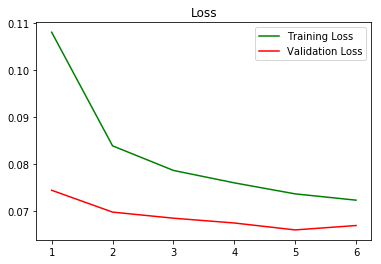

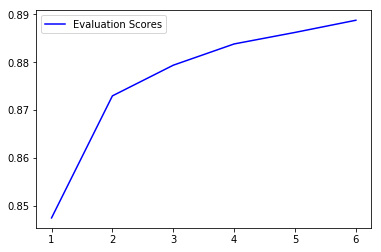

In [66]:
epch = range(1, EPOCHS + 1)
plt.plot(epch, train_losses, 'g', label='Training Loss')
plt.plot(epch, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.figure()
plt.plot(epch, eval_scores, 'b', label='Evaluation Scores')
plt.legend()
plt.show()

(array([7687.,  350.,  194.,  161.,  130.,  133.,  118.,   92.,   78.,
          82.]),
 array([3.32295895e-04, 1.00138076e-01, 1.99943855e-01, 2.99749643e-01,
        3.99555415e-01, 4.99361187e-01, 5.99166989e-01, 6.98972762e-01,
        7.98778534e-01, 8.98584306e-01, 9.98390079e-01], dtype=float32),
 <a list of 10 Patch objects>)

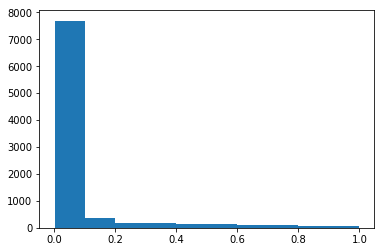

In [67]:
plt.hist(val_preds)

### Subgroup Results

In [82]:
pd.DataFrame(JE.compute_bias_metrics_for_model(val_preds).T, 
             index = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness'], 
             columns = ['subgroup_auc', 'bpsn_auc', 'bnsp_auc'])

,subgroup_auc,bpsn_auc,bnsp_auc
male,0.880287,0.922630,0.928018
female,0.939323,0.926062,0.958435
homosexual_gay_or_lesbian,0.855556,0.804138,0.970154
christian,0.884777,0.956381,0.879029
jewish,0.907692,0.917550,0.926251
muslim,0.835206,0.889614,0.927385
black,0.842576,0.771031,0.975152
white,0.826994,0.827415,0.956503
psychiatric_or_mental_illness,0.884615,0.962158,0.848859


## Model 3: Bidirectional LSTM x2 with BERT Embeddings

In [68]:
def build_model2(embedding_matrix):
    '''
    credits go to: https://www.kaggle.com/thousandvoices/simple-lstm/
    '''
    words = Input(shape=(MAXLEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x)])
    x = Dropout(0.5)(x)
    x = Dense(DENSE_HIDDEN_UNITS, activation='relu')(x)
    x = Dropout(0.3)(x)
    result = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss=custom_loss, optimizer='adam')

    return model

In [69]:
model2 = build_model2(embedding_matrix)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 220, 768)     23440896    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 220, 768)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 220, 256)     919552      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [70]:
plot_model(model2, to_file='bi-lstm-model2.png')

In [83]:
eval_scores2 = []
train_losses2 = []
val_losses2 = []

for global_epoch in range(EPOCHS):
    history = model.fit(x_train[tr_ind],y_train[tr_ind],validation_data = (x_train[val_ind],y_train[val_ind]),
        batch_size=BATCH_SIZE,
        epochs=1,
        verbose=1,
        callbacks=[
            LearningRateScheduler(lambda epoch: 1e-3 * (0.8 ** global_epoch))
        ]
    )
    #checkpoint_predictions.append(model.predict(x_test, batch_size=BATCH_SIZE)[0].flatten())
    gc.collect()
    val_preds2 = model.predict(x_train[val_ind], batch_size=BATCH_SIZE)
    JE2 = JigsawEvaluator(y_train[val_ind][:,0],y_identities[val_ind])
    eval_scores2.append(JE2.get_final_metric(val_preds))
    train_losses2.append(history.history['loss'])
    val_losses2.append(history.history['val_loss'])

Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:32 - loss: 0.060 - ETA: 2:27 - loss: 0.062 - ETA: 2:25 - loss: 0.068 - ETA: 2:23 - loss: 0.068 - ETA: 2:23 - loss: 0.064 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.066 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.066 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.065 - ETA: 2:23 - loss: 0.067 - ETA: 2:23 - loss: 0.065 - ETA: 2:23 - loss: 0.066 - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.063 - ETA: 2:23 - loss: 0.063 - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:22 - loss: 0.062 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.064 - ETA: 2:22 - loss: 0.063 - ETA: 2:22 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:23 - loss: 0.064 - ETA: 2:24 - loss: 0.064 - ETA: 2:24 - los

 80000/171462 [============>.................] - ETA: 1:54 - loss: 0.063 - ETA: 1:54 - loss: 0.063 - ETA: 1:54 - loss: 0.063 - ETA: 1:53 - loss: 0.064 - ETA: 1:53 - loss: 0.064 - ETA: 1:53 - loss: 0.064 - ETA: 1:53 - loss: 0.063 - ETA: 1:53 - loss: 0.063 - ETA: 1:53 - loss: 0.063 - ETA: 1:53 - loss: 0.063 - ETA: 1:53 - loss: 0.063 - ETA: 1:53 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:52 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:51 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - loss: 0.063 - ETA: 1:50 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:19 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:18 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:17 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:16 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - loss: 0.063 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.063 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:32 - loss: 0.058 - ETA: 2:28 - loss: 0.055 - ETA: 2:25 - loss: 0.051 - ETA: 2:24 - loss: 0.063 - ETA: 2:25 - loss: 0.065 - ETA: 2:24 - loss: 0.065 - ETA: 2:24 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.056 - ETA: 2:23 - loss: 0.057 - ETA: 2:22 - loss: 0.055 - ETA: 2:22 - loss: 0.058 - ETA: 2:21 - loss: 0.061 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.057 - ETA: 2:21 - loss: 0.055 - ETA: 2:21 - loss: 0.058 - ETA: 2:21 - loss: 0.058 - ETA: 2:22 - loss: 0.056 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.058 - ETA: 2:23 - loss: 0.058 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.059 - ETA: 2:23 - loss: 0.059 - ETA: 2:22 - loss: 0.060 - ETA: 2:23 - loss: 0.059 - ETA: 2:23 - los

 80000/171462 [============>.................] - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:53 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.062 - ETA: 1:52 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:50 - loss: 0.061 - ETA: 1:49 - loss: 0.061 - ETA: 1:49 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:18 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:17 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:16 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:32 - loss: 0.042 - ETA: 2:26 - loss: 0.060 - ETA: 2:25 - loss: 0.067 - ETA: 2:22 - loss: 0.067 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.056 - ETA: 2:22 - loss: 0.054 - ETA: 2:21 - loss: 0.055 - ETA: 2:21 - loss: 0.057 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.060 - ETA: 2:20 - loss: 0.060 - ETA: 2:20 - loss: 0.063 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.060 - ETA: 2:20 - loss: 0.062 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.060 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:20 - loss: 0.061 - ETA: 2:19 - loss: 0.061 - ETA: 2:19 - loss: 0.060 - ETA: 2:19 - loss: 0.060 - ETA: 2:19 - loss: 0.060 - ETA: 2:19 - loss: 0.061 - ETA: 2:19 - loss: 0.061 - ETA: 2:19 - loss: 0.061 - ETA: 2:19 - loss: 0.062 - ETA: 2:19 - loss: 0.063 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - loss: 0.064 - ETA: 2:19 - los

 80000/171462 [============>.................] - ETA: 1:53 - loss: 0.061 - ETA: 1:53 - loss: 0.061 - ETA: 1:53 - loss: 0.061 - ETA: 1:53 - loss: 0.061 - ETA: 1:53 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:52 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.061 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:51 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:50 - loss: 0.062 - ETA: 1:49 - loss: 0.062 - ETA: 1:49 - loss: 0.062 - ETA: 1:49 - loss: 0.062 - ETA: 1:49 - loss: 0.062 - ETA: 1:49 - los

121600/171462 [====================>.........] - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:18 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:17 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:16 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.061 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:15 - loss: 0.062 - ETA: 1:14 - los

165120/171462 [===========================>..] - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 39s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss: 0.06 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:33 - loss: 0.044 - ETA: 2:26 - loss: 0.067 - ETA: 2:26 - loss: 0.057 - ETA: 2:25 - loss: 0.054 - ETA: 2:24 - loss: 0.050 - ETA: 2:23 - loss: 0.047 - ETA: 2:22 - loss: 0.049 - ETA: 2:22 - loss: 0.050 - ETA: 2:21 - loss: 0.049 - ETA: 2:22 - loss: 0.048 - ETA: 2:22 - loss: 0.049 - ETA: 2:22 - loss: 0.048 - ETA: 2:22 - loss: 0.050 - ETA: 2:22 - loss: 0.050 - ETA: 2:22 - loss: 0.048 - ETA: 2:22 - loss: 0.049 - ETA: 2:22 - loss: 0.050 - ETA: 2:22 - loss: 0.052 - ETA: 2:22 - loss: 0.051 - ETA: 2:22 - loss: 0.052 - ETA: 2:23 - loss: 0.053 - ETA: 2:23 - loss: 0.055 - ETA: 2:23 - loss: 0.054 - ETA: 2:23 - loss: 0.056 - ETA: 2:23 - loss: 0.056 - ETA: 2:22 - loss: 0.058 - ETA: 2:23 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - los

 80000/171462 [============>.................] - ETA: 1:54 - loss: 0.059 - ETA: 1:54 - loss: 0.059 - ETA: 1:54 - loss: 0.059 - ETA: 1:54 - loss: 0.059 - ETA: 1:54 - loss: 0.059 - ETA: 1:53 - loss: 0.059 - ETA: 1:53 - loss: 0.059 - ETA: 1:53 - loss: 0.060 - ETA: 1:53 - loss: 0.060 - ETA: 1:53 - loss: 0.060 - ETA: 1:53 - loss: 0.060 - ETA: 1:53 - loss: 0.059 - ETA: 1:53 - loss: 0.059 - ETA: 1:53 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.060 - ETA: 1:51 - loss: 0.060 - ETA: 1:51 - loss: 0.060 - ETA: 1:51 - loss: 0.060 - ETA: 1:51 - loss: 0.060 - ETA: 1:51 - loss: 0.060 - ETA: 1:50 - loss: 0.060 - ETA: 1:50 - loss: 0.060 - ETA: 1:50 - loss: 0.060 - ETA: 1:50 - loss: 0.060 - ETA: 1:50 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:19 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:18 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:17 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:16 - loss: 0.060 - ETA: 1:15 - loss: 0.060 - ETA: 1:15 - loss: 0.060 - ETA: 1:15 - loss: 0.060 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.06 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 42s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 41s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.06 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 4s - loss: 0.060 - ETA: 4s - loss: 0.060 - ETA: 4s - loss: 0.060 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.060 - ETA: 4s - loss: 0.060 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 2s - loss: 0.060 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:43 - loss: 0.052 - ETA: 2:37 - loss: 0.063 - ETA: 2:36 - loss: 0.063 - ETA: 2:33 - loss: 0.059 - ETA: 2:31 - loss: 0.057 - ETA: 2:29 - loss: 0.057 - ETA: 2:27 - loss: 0.058 - ETA: 2:27 - loss: 0.056 - ETA: 2:26 - loss: 0.059 - ETA: 2:26 - loss: 0.058 - ETA: 2:25 - loss: 0.058 - ETA: 2:25 - loss: 0.056 - ETA: 2:24 - loss: 0.055 - ETA: 2:24 - loss: 0.056 - ETA: 2:24 - loss: 0.058 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.057 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.057 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.060 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.057 - ETA: 2:21 - loss: 0.059 - ETA: 2:21 - loss: 0.059 - ETA: 2:21 - loss: 0.060 - ETA: 2:21 - los

 80000/171462 [============>.................] - ETA: 1:53 - loss: 0.058 - ETA: 1:53 - loss: 0.058 - ETA: 1:53 - loss: 0.058 - ETA: 1:53 - loss: 0.058 - ETA: 1:52 - loss: 0.058 - ETA: 1:52 - loss: 0.058 - ETA: 1:52 - loss: 0.058 - ETA: 1:52 - loss: 0.058 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:52 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.059 - ETA: 1:51 - loss: 0.058 - ETA: 1:51 - loss: 0.058 - ETA: 1:51 - loss: 0.058 - ETA: 1:51 - loss: 0.058 - ETA: 1:51 - loss: 0.058 - ETA: 1:51 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.058 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:50 - loss: 0.059 - ETA: 1:49 - loss: 0.059 - ETA: 1:49 - loss: 0.059 - ETA: 1:49 - loss: 0.059 - ETA: 1:49 - loss: 0.059 - ETA: 1:49 - loss: 0.059 - ETA: 1:49 - los

121600/171462 [====================>.........] - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:18 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:17 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:16 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:15 - loss: 0.058 - ETA: 1:14 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 39808/171462 [=====>........................] - ETA: 2:37 - loss: 0.037 - ETA: 2:30 - loss: 0.044 - ETA: 2:27 - loss: 0.047 - ETA: 2:26 - loss: 0.051 - ETA: 2:25 - loss: 0.059 - ETA: 2:25 - loss: 0.059 - ETA: 2:24 - loss: 0.057 - ETA: 2:24 - loss: 0.061 - ETA: 2:24 - loss: 0.058 - ETA: 2:24 - loss: 0.056 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.057 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.061 - ETA: 2:23 - loss: 0.061 - ETA: 2:24 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.061 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.060 - ETA: 2:23 - loss: 0.061 - ETA: 2:23 - loss: 0.059 - ETA: 2:23 - loss: 0.061 - ETA: 2:23 - loss: 0.060 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - loss: 0.059 - ETA: 2:22 - loss: 0.058 - ETA: 2:22 - los

 80000/171462 [============>.................] - ETA: 1:54 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:53 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:52 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:51 - loss: 0.057 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - loss: 0.058 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - loss: 0.057 - ETA: 1:50 - los

121600/171462 [====================>.........] - ETA: 1:19 - loss: 0.057 - ETA: 1:19 - loss: 0.057 - ETA: 1:19 - loss: 0.057 - ETA: 1:19 - loss: 0.057 - ETA: 1:19 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:18 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:17 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:16 - loss: 0.057 - ETA: 1:15 - loss: 0.057 - ETA: 1:15 - loss: 0.057 - ETA: 1:15 - loss: 0.057 - ETA: 1:15 - loss: 0.057 - ETA: 1:15 - los

165120/171462 [===========================>..] - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss

171462/171462 [==============================] - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss: 0.057 - ETA: 1s - loss:

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


In [72]:
train_losses2

[[0.0736421179212128],
 [0.07160280915172841],
 [0.0698004203868779],
 [0.06858280758044052],
 [0.06736215332005048],
 [0.06659268059696921]]

In [73]:
eval_scores2

[0.8920447724447054,
 0.893168990564035,
 0.8953909696638873,
 0.8970317977755273,
 0.8996202513963552,
 0.902068124505687]

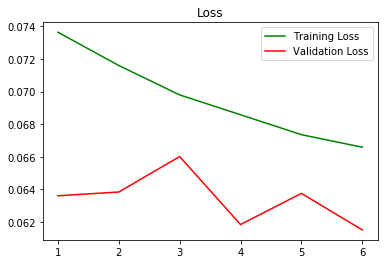

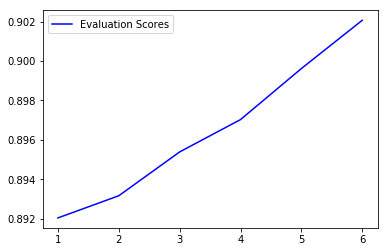

In [74]:
epch = range(1, EPOCHS + 1)
plt.plot(epch, train_losses2, 'g', label='Training Loss')
plt.plot(epch, val_losses2, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.figure()
plt.plot(epch, eval_scores2, 'b', label='Evaluation Scores')
plt.legend()
plt.show()

### Subgroup Results

In [85]:
subgroup_metrics = pd.DataFrame(JE2.compute_bias_metrics_for_model(val_preds2).T, 
             index = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness'], 
             columns = ['subgroup_auc', 'bpsn_auc', 'bnsp_auc'])
subgroup_metrics

,subgroup_auc,bpsn_auc,bnsp_auc
male,0.880895,0.922398,0.927786
female,0.939323,0.922729,0.961082
homosexual_gay_or_lesbian,0.844444,0.776679,0.975482
christian,0.895251,0.954350,0.889616
jewish,0.884615,0.909035,0.930654
muslim,0.823435,0.883507,0.929007
black,0.828265,0.772403,0.973775
white,0.822485,0.839252,0.950232
psychiatric_or_mental_illness,0.884615,0.968690,0.845495


# Interpreting the Model

This model with two Bidirectional LSTM models succeeds in classifying toxic comments, with a weighted ROC-AUC metric score of 0.902. This is better than the 0.827 score for the Naive Bayes model and the 0.884 score for the benchmark Kernel on Kaggle. I suspect the score would improve further with additional data and learning epochs. 

The subgroup metrics indicate that this model has varying success with correctly classifying toxic comments mentioning certain subgroups. For example, the black and white subgroups have low scores, possible because of the non-racial uses of those words. In contrast, the female subgroup has relatively strong AUC metrics, suggesting that it is easier to classify comments mentioning women as toxic or non-toxic.